In [20]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

from process import Process
from scipy import ndimage
import pandas as pd
from scipy import stats


In [21]:
image_path_left = './data/images/im0.png'
image_path_right = './data/images/im1.png'

In [22]:


class Process:

    def __init__(self, image):

        self.image = Image.open(image)

        self.image = self.image.convert('L')

    def get_info(self):

        """
        Get Image size and mode information using the Pillow library.

        Return:
            (size, mode)
        """
        im = self.image
        print(f"Image size: {im.size}")
        print(f"Image mode: {im.mode}")

        return im.size, im.mode

    def get_array(self):

        """
        Get Numpy array for the input image
        """

        self.array = np.array(self.image, dtype='int64')

        return self.array

    def resize_image(self, width, height):

        new_dim = (width, height)
        self.image = self.image.resize(new_dim)

        return 

    def slice_image(self, xi, yi, size):

        self.slice = self.array[xi:(xi + size), yi:(yi + size)]

        return self.slice

    def show_image(self):

        self.image.show()

        return


In [23]:
imL = Process(image_path_left)
imL.resize_image(357, 250)
arrL = imL.get_array()
imL.get_info()

imR = Process(image_path_right)
imR.resize_image(357, 250)
arrR = imR.get_array()
imR.get_info()

Image size: (357, 250)
Image mode: L
Image size: (357, 250)
Image mode: L


((357, 250), 'L')

In [24]:


# activate for laplacian filter
arrL_filtered = ndimage.laplace(arrL)
arrR_filtered = ndimage.laplace(arrR)

array_left = arrL
array_right = arrR

In [25]:
"""
Calculate Disparity using Sum of Absolute Differences Method (SAD)
__________________________________________________________________

Region matching between windows in the left and right images using the SAD method. 
Modify 'size' and 'search_range' to alter results.
"""

size = 11

search_range = 44

start_time = time.time()

disp_matrix = []

for row in range(len(arrL_filtered) - size):

    if row % 10 == 0:
        print(f"{row} rows completed.")

    disps = []

    for col1 in range(len(arrL_filtered[row]) - size):
        win1 = arrL_filtered[row:row + size, col1:col1 + size].flatten()

        if col1 < search_range:
            init = 0
        else:
            init = col1 - search_range

        sads = []

        for col2 in range(col1, init - 1, -1):
            win2 = arrR_filtered[row:row + size, col2:col2 + size].flatten()

            sad = np.sum(np.abs(np.subtract(win1, win2)))
            sads.append(sad)

        disparity = np.argmin(sads)
        disps.append(disparity)

    disp_matrix.append(disps)
            
        
disp_matrix = np.array(disp_matrix)

end_time = time.time()

print(f"Total runtime: {end_time - start_time}")
print(disp_matrix.shape)

0 rows completed.
10 rows completed.
20 rows completed.
30 rows completed.
40 rows completed.
50 rows completed.
60 rows completed.
70 rows completed.
80 rows completed.
90 rows completed.
100 rows completed.
110 rows completed.
120 rows completed.
130 rows completed.
140 rows completed.
150 rows completed.
160 rows completed.
170 rows completed.
180 rows completed.
190 rows completed.
200 rows completed.
210 rows completed.
220 rows completed.
230 rows completed.
Total runtime: 15.594510078430176
(239, 346)


In [26]:
"""
Calculate Disparity using Correlation Coefficient Method (CC)
__________________________________________________________________

Region matching between windows in the left and right images using the CC method. 
Modify 'size' and 'search_range' to alter results.
"""
window_size = 11

search_range = 44

start_time = time.time()

disp_matrix = []

for row in range(len(arrL_filtered) - size):

    if row % 10 == 0:
        print(f"{row} rows completed.")

    disps = []
 
    for col1 in range(len(array_left[row]) - window_size):
        win1 = array_left[row:row + window_size, col1:col1 + window_size].flatten()
        avg1 = np.average(win1)
        var1 = np.subtract(win1, avg1)

        if col1 < search_range:
            init = 0
        else:
            init = col1 - search_range

        if col1 > (len(array_left[row]) - window_size - search_range):
            final = len(array_left[row]) - window_size
        else:
            final = col1 + search_range

        corrs = []
        for col2 in range(col1, init - 1, -1):
            win2 = array_right[row:row + window_size, col2:col2 + window_size].flatten()

            avg2 = np.average(win2)
            var2 = np.subtract(win2, avg2)

            if (np.sqrt((np.sum(np.square(var1))) * (np.sum(np.square(var2))))) == 0:
                r = 0.9999999999999999

            else:
                r = (np.sum(np.multiply(var1, var2))) / np.sqrt((np.sum(np.square(var1))) * (np.sum(np.square(var2))))

            corrs.append(r)

        disparity = np.argmax(corrs)
        disps.append(disparity)

    disp_matrix.append(disps)
            
        
disp_matrix = np.array(disp_matrix)

end_time = time.time()

print(f"Total runtime: {end_time - start_time}")
print(disp_matrix.shape)

0 rows completed.
10 rows completed.
20 rows completed.
30 rows completed.
40 rows completed.
50 rows completed.
60 rows completed.
70 rows completed.
80 rows completed.
90 rows completed.
100 rows completed.
110 rows completed.
120 rows completed.
130 rows completed.
140 rows completed.
150 rows completed.
160 rows completed.
170 rows completed.
180 rows completed.
190 rows completed.
200 rows completed.
210 rows completed.
220 rows completed.
230 rows completed.
Total runtime: 83.69246196746826
(239, 346)


In [9]:
"""
Recycle Bin Image Calibration
_____________________________

Calculate the z-coordinate for each pixel using constants in 'calib.txt'
"""

z_matrix = np.copy(disp_matrix)

for i in np.nditer(z_matrix):
    i = 178.232 * 2945.377 / (i + 170.681)

z_matrix

array([[ 0,  0,  0, ..., 15, 15, 15],
       [ 0,  0,  0, ..., 15, 15, 14],
       [ 0,  0,  0, ..., 14, 14, 14],
       ...,
       [ 0,  0,  1, ..., 14, 14, 14],
       [ 0,  0,  1, ..., 14, 14, 15],
       [ 0,  0,  1, ..., 14, 15, 15]])

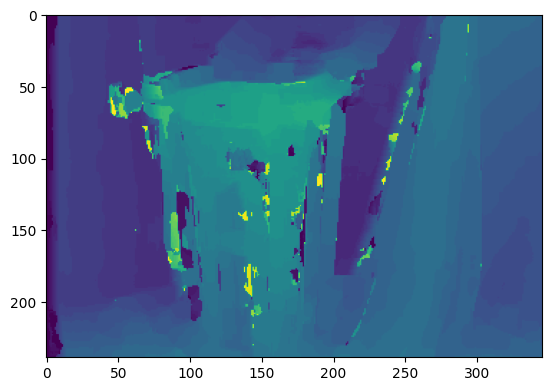

In [10]:
plt.imshow(disp_matrix)
# plt.savefig('./data/output/MPL.png')

In [11]:
"""
Optional: Save matrix in a .pkl file for future usage.
"""

import pickle

with open('./data/output/z.pkl', 'wb') as f:
    pickle.dump(z_matrix, f)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/b4/pg3rpq6542xdykqyms1rd2740000gn/T/ipykernel_33191/3009964817.py:46: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(avg_disp[y-12:y+13, x-12:x+13].flatten())


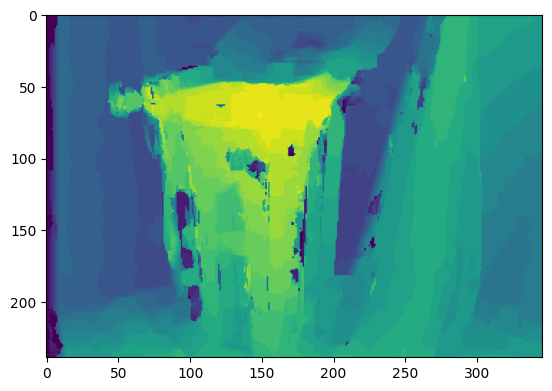

In [12]:
"""
Post-processing
_______________

Take the output matrix from disparity calculations and handle noise and discontinuities.

Noise:

    - Mode Method: Calculate the mode value in a large window around each pixel; assign to value if exceeds threshold.

    - Threshold Cutoff Method: Flatten any extraneous pixels above a threshold to a preset value.

Discontinuity:

    - Average Method: Calculate the average in small window around each pixel; assign value if difference between disparity
                      and value exceed a threshold.

"""

from process import Process

import pandas as pd
from scipy import stats

raw_img = './data/images/im0.png'

img = Image.open(raw_img)
img = img.resize((disp_matrix.shape[1], disp_matrix.shape[0]))
arr = np.array(img)

xyzrgb = []

avg_disp = np.copy(disp_matrix)

for x in range(disp_matrix.shape[1]):
    for y in range(disp_matrix.shape[0]):

        # MEAN
        avg = np.mean(avg_disp[y-7:y+8, x-7:x+8])
        if avg_disp[y, x] - avg > 5:
            avg_disp[y, x] = avg

        # MODE
        if x > 12 and x < 227:
            if avg_disp[y, x] > 25:
                mode = stats.mode(avg_disp[y-12:y+13, x-12:x+13].flatten())
                avg_disp[y, x] = mode[0][0]

        # THRESHOLD
        if avg_disp[y, x] > 30:
            avg_disp[y, x] = 25

        z = np.multiply(avg_disp[y, x], 6)
        rgb = arr[y, x]
        xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])

df = pd.DataFrame(xyzrgb)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df.to_csv('./data/output/point_cloud.txt', index=False)
plt.imshow(avg_disp)
plt.savefig('./data/output/disp_MPL.png')